In [1]:
from contour import *
from fourier import *
import cv2
import random as rng
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from symfit import parameters, variables, sin, cos, Fit
from tqdm import trange
import sympy
%matplotlib inline

In [23]:
src = cv2.imread(cv2.samples.findFile("test2.jpg"))
threshold = 100
contours, contours_simple = find_egg_contour(src.copy(), threshold)
for i in range(len(contours)):
    color = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
    cv2.drawContours(src, contours, i, color, thickness=2, lineType=cv2.LINE_AA)

source_window = 'Contours'
cv2.namedWindow(source_window)
cv2.imshow(source_window, src)
cv2.waitKey()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x37ceb50) is not the object's thread (0x32f5580).
Cannot move to target thread (0x37ceb50)

QObject::moveToThread: Current thread (0x37ceb50) is not the object's thread (0x32f5580).
Cannot move to target thread (0x37ceb50)

QObject::moveToThread: Current thread (0x37ceb50) is not the object's thread (0x32f5580).
Cannot move to target thread (0x37ceb50)

QObject::moveToThread: Current thread (0x37ceb50) is not the object's thread (0x32f5580).
Cannot move to target thread (0x37ceb50)

QObject::moveToThread: Current thread (0x37ceb50) is not the object's thread (0x32f5580).
Cannot move to target thread (0x37ceb50)

QObject::moveToThread: Current thread (0x37ceb50) is not the object's thread (0x32f5580).
Cannot move to target thread (0x37ceb50)

QObject::moveToThread: Current thread (0x37ceb50) is not the object's thread (0x32f5580).
Cannot move to target thread (0x37ceb50)

QObject::moveToThread: Current thread (0x37ceb50) is not the object's thread

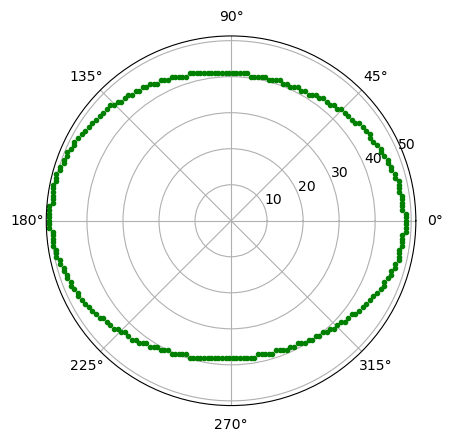

In [24]:
contours = np.array(contours)
_, length, _, coor = contours.shape
contours = contours.reshape((length, coor))
contours = transform2world(contours, src_img=src)
radius, radiances = cart2pol(contours[:, 0], contours[:, 1])

plt.axes(projection = 'polar') 
plt.polar(radiances, radius, 'g.') 

In [25]:
# AS = cv2.contourArea(contours)
# PL = cv2.arcLength(contours, True)

100%|███████████████████████████████████████████████████████████████████████████████████| 48/48 [13:22<00:00, 16.72s/it]


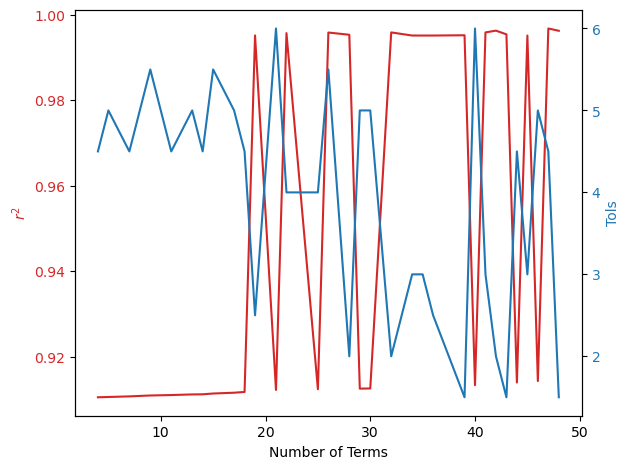

In [26]:
def fourier_series(phi, w, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(f'a:{n + 1}')
    sin_b = parameters(','.join([f'b{i}' for i in range(1, n + 1)]))
    series = a0 + sum(ai * cos(i * w * phi) + bi * sin(i * w * phi) for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

def get_fit(r, phi, w, n):
    fit_func = None
    fit_para = None
    fit_model = None
    tol = 0
    r_square_value = 0
    max_r = 0
    model_dict = {r: fourier_series(phi, w=w, n=n)}
    fit = Fit(model_dict, phi=radiances, r=radius)
    for a in np.arange(1, 10, 0.5):
        fit_result = fit.execute(options={'gtol': 10**(-a)})
        if 'successfully' in fit_result.status_message:
            r_square_value = fit_result.gof_qualifiers['r_squared']
            if r_square_value > max_r:
                max_r = r_square_value
                fit_func = fit
                fit_para = fit_result.params
                fit_model = model_dict
                tol = a
        else:
            break
    return fit_func, fit_para, fit_model, r_square_value, tol

r, phi = variables('r, phi')
x, y = sympy.symbols('x, y')
w, = parameters('w')

model_info = {
    "num_term": [],
    "r_sqaure": [],
    "tol": [],
    "func": [],
    "para": [],
    "model": [],
}

for i in trange(2, 50):
    fit_func, fit_para, fit_model, r_square_value, tol = get_fit(r, phi, w, i)
    if tol > 0 and r_square_value > 0.5:
        model_info["num_term"].append(i)
        model_info["r_sqaure"].append(r_square_value)
        model_info["tol"].append(tol)
        model_info["func"].append(fit_func)
        model_info["para"].append(fit_para)
        model_info["model"].append(fit_model)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Number of Terms')
ax1.set_ylabel('$r^2$', color=color)
ax1.plot(model_info["num_term"], model_info["r_sqaure"], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Tols', color=color)
ax2.plot(model_info["num_term"], model_info["tol"], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

Best Fitted has 25 terms,
with r_square = 0.9124131982196576 and tol = 4.0


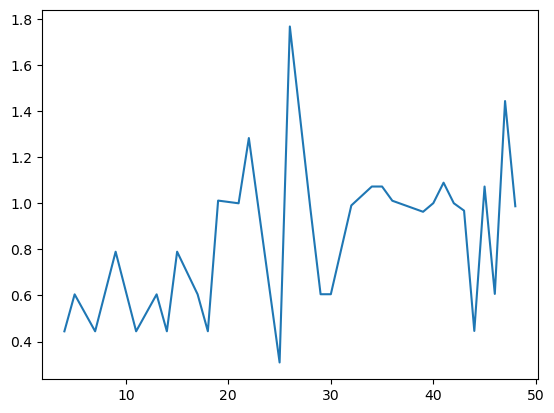

In [27]:
tol_array = np.array(model_info["tol"])
normalized_tol = (tol_array - np.min(tol_array)) / (np.max(tol_array) - np.min(tol_array))
r_square_array = np.array(model_info["r_sqaure"])
normalized_r = (r_square_array - np.min(r_square_array)) / (np.max(r_square_array) - np.min(r_square_array))
cost = normalized_r ** 2 + normalized_tol **2
best_fit_idx = np.argmin(cost)
print(f'Best Fitted has {model_info["num_term"][best_fit_idx]} terms,\nwith r_square = {model_info["r_sqaure"][best_fit_idx]} and tol = {model_info["tol"][best_fit_idx]}')

fitted_model = model_info["model"][best_fit_idx]
fitted_para = model_info["para"][best_fit_idx]
fitted_func = model_info["func"][best_fit_idx]

fig, ax = plt.subplots()
ax.plot(model_info["num_term"], cost, color=color)

In [28]:
r = fitted_model[r]
r

a0 + a1*cos(w*phi) + a10*cos(10*w*phi) + a11*cos(11*w*phi) + a12*cos(12*w*phi) + a13*cos(13*w*phi) + a14*cos(14*w*phi) + a15*cos(15*w*phi) + a16*cos(16*w*phi) + a17*cos(17*w*phi) + a18*cos(18*w*phi) + a19*cos(19*w*phi) + a2*cos(2*w*phi) + a20*cos(20*w*phi) + a21*cos(21*w*phi) + a22*cos(22*w*phi) + a23*cos(23*w*phi) + a24*cos(24*w*phi) + a25*cos(25*w*phi) + a3*cos(3*w*phi) + a4*cos(4*w*phi) + a5*cos(5*w*phi) + a6*cos(6*w*phi) + a7*cos(7*w*phi) + a8*cos(8*w*phi) + a9*cos(9*w*phi) + b1*sin(w*phi) + b10*sin(10*w*phi) + b11*sin(11*w*phi) + b12*sin(12*w*phi) + b13*sin(13*w*phi) + b14*sin(14*w*phi) + b15*sin(15*w*phi) + b16*sin(16*w*phi) + b17*sin(17*w*phi) + b18*sin(18*w*phi) + b19*sin(19*w*phi) + b2*sin(2*w*phi) + b20*sin(20*w*phi) + b21*sin(21*w*phi) + b22*sin(22*w*phi) + b23*sin(23*w*phi) + b24*sin(24*w*phi) + b25*sin(25*w*phi) + b3*sin(3*w*phi) + b4*sin(4*w*phi) + b5*sin(5*w*phi) + b6*sin(6*w*phi) + b7*sin(7*w*phi) + b8*sin(8*w*phi) + b9*sin(9*w*phi)

In [29]:
x = r * sympy.cos(phi)
x

(a0 + a1*cos(w*phi) + a10*cos(10*w*phi) + a11*cos(11*w*phi) + a12*cos(12*w*phi) + a13*cos(13*w*phi) + a14*cos(14*w*phi) + a15*cos(15*w*phi) + a16*cos(16*w*phi) + a17*cos(17*w*phi) + a18*cos(18*w*phi) + a19*cos(19*w*phi) + a2*cos(2*w*phi) + a20*cos(20*w*phi) + a21*cos(21*w*phi) + a22*cos(22*w*phi) + a23*cos(23*w*phi) + a24*cos(24*w*phi) + a25*cos(25*w*phi) + a3*cos(3*w*phi) + a4*cos(4*w*phi) + a5*cos(5*w*phi) + a6*cos(6*w*phi) + a7*cos(7*w*phi) + a8*cos(8*w*phi) + a9*cos(9*w*phi) + b1*sin(w*phi) + b10*sin(10*w*phi) + b11*sin(11*w*phi) + b12*sin(12*w*phi) + b13*sin(13*w*phi) + b14*sin(14*w*phi) + b15*sin(15*w*phi) + b16*sin(16*w*phi) + b17*sin(17*w*phi) + b18*sin(18*w*phi) + b19*sin(19*w*phi) + b2*sin(2*w*phi) + b20*sin(20*w*phi) + b21*sin(21*w*phi) + b22*sin(22*w*phi) + b23*sin(23*w*phi) + b24*sin(24*w*phi) + b25*sin(25*w*phi) + b3*sin(3*w*phi) + b4*sin(4*w*phi) + b5*sin(5*w*phi) + b6*sin(6*w*phi) + b7*sin(7*w*phi) + b8*sin(8*w*phi) + b9*sin(9*w*phi))*cos(phi)

In [30]:
y = r * sympy.sin(phi)
y

(a0 + a1*cos(w*phi) + a10*cos(10*w*phi) + a11*cos(11*w*phi) + a12*cos(12*w*phi) + a13*cos(13*w*phi) + a14*cos(14*w*phi) + a15*cos(15*w*phi) + a16*cos(16*w*phi) + a17*cos(17*w*phi) + a18*cos(18*w*phi) + a19*cos(19*w*phi) + a2*cos(2*w*phi) + a20*cos(20*w*phi) + a21*cos(21*w*phi) + a22*cos(22*w*phi) + a23*cos(23*w*phi) + a24*cos(24*w*phi) + a25*cos(25*w*phi) + a3*cos(3*w*phi) + a4*cos(4*w*phi) + a5*cos(5*w*phi) + a6*cos(6*w*phi) + a7*cos(7*w*phi) + a8*cos(8*w*phi) + a9*cos(9*w*phi) + b1*sin(w*phi) + b10*sin(10*w*phi) + b11*sin(11*w*phi) + b12*sin(12*w*phi) + b13*sin(13*w*phi) + b14*sin(14*w*phi) + b15*sin(15*w*phi) + b16*sin(16*w*phi) + b17*sin(17*w*phi) + b18*sin(18*w*phi) + b19*sin(19*w*phi) + b2*sin(2*w*phi) + b20*sin(20*w*phi) + b21*sin(21*w*phi) + b22*sin(22*w*phi) + b23*sin(23*w*phi) + b24*sin(24*w*phi) + b25*sin(25*w*phi) + b3*sin(3*w*phi) + b4*sin(4*w*phi) + b5*sin(5*w*phi) + b6*sin(6*w*phi) + b7*sin(7*w*phi) + b8*sin(8*w*phi) + b9*sin(9*w*phi))*sin(phi)

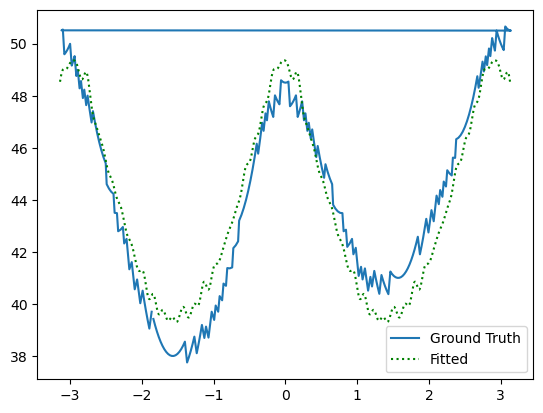

In [31]:
plt.plot(radiances, radius, label="Ground Truth")
phi_domain = np.linspace(-np.pi, np.pi - 0.01, 10000)
r_data = fitted_func.model(phi=phi_domain, **fitted_para).r
plt.plot(phi_domain, r_data, color='green', ls=':', label="Fitted")
plt.legend()

In [32]:
def curvature(x, y):
    dx_dphi = sympy.diff(x, phi)
    dy_dphi = sympy.diff(y, phi)
    d2x_dphi2 = sympy.diff(dx_dphi, phi)
    d2y_dphi2 = sympy.diff(dy_dphi, phi)
    R = sympy.sqrt(dx_dphi**2 + dx_dphi**2)**3 / abs(dx_dphi * d2y_dphi2 - dy_dphi * d2x_dphi2)
    return R
R = curvature(x, y)
R

2*sqrt(2)*((a1*w*sin(w*phi) + 10*a10*w*sin(10*w*phi) + 11*a11*w*sin(11*w*phi) + 12*a12*w*sin(12*w*phi) + 13*a13*w*sin(13*w*phi) + 14*a14*w*sin(14*w*phi) + 15*a15*w*sin(15*w*phi) + 16*a16*w*sin(16*w*phi) + 17*a17*w*sin(17*w*phi) + 18*a18*w*sin(18*w*phi) + 19*a19*w*sin(19*w*phi) + 2*a2*w*sin(2*w*phi) + 20*a20*w*sin(20*w*phi) + 21*a21*w*sin(21*w*phi) + 22*a22*w*sin(22*w*phi) + 23*a23*w*sin(23*w*phi) + 24*a24*w*sin(24*w*phi) + 25*a25*w*sin(25*w*phi) + 3*a3*w*sin(3*w*phi) + 4*a4*w*sin(4*w*phi) + 5*a5*w*sin(5*w*phi) + 6*a6*w*sin(6*w*phi) + 7*a7*w*sin(7*w*phi) + 8*a8*w*sin(8*w*phi) + 9*a9*w*sin(9*w*phi) - b1*w*cos(w*phi) - 10*b10*w*cos(10*w*phi) - 11*b11*w*cos(11*w*phi) - 12*b12*w*cos(12*w*phi) - 13*b13*w*cos(13*w*phi) - 14*b14*w*cos(14*w*phi) - 15*b15*w*cos(15*w*phi) - 16*b16*w*cos(16*w*phi) - 17*b17*w*cos(17*w*phi) - 18*b18*w*cos(18*w*phi) - 19*b19*w*cos(19*w*phi) - 2*b2*w*cos(2*w*phi) - 20*b20*w*cos(20*w*phi) - 21*b21*w*cos(21*w*phi) - 22*b22*w*cos(22*w*phi) - 23*b23*w*cos(23*w*phi) - 24*b

In [33]:
# TODO: Check upper and lower limit (seems not to be 0-pi)
# def volume(r, phi, x):
#     dx_dphi = sympy.diff(x, phi)
#     V = sympy.pi * sympy.Integral(r * r * sympy.sin(phi) * sympy.sin(phi) * dx_dphi, (phi, 0, sympy.pi))
#     return V
# V = volume(r, phi, x)
# V

In [34]:
# def surface(r, phi, x, y):
#     dx_dphi = sympy.diff(x, phi)
#     dy_dphi = sympy.diff(y, phi)
#     S = 2 * sympy.pi * sympy.Integral(r * sympy.sin(phi) * dx_dphi * sympy.sqrt(dx_dphi * dx_dphi + dy_dphi * dy_dphi), (phi, 0, sympy.pi))
#     return S
# S = surface(r, phi, x, y)
# S

In [35]:
sub_symbols = dict(fitted_para)
sub_values = {}
for symbol in R.free_symbols:
    if str(symbol) in sub_symbols.keys():
        sub_values[symbol] = sub_symbols[str(symbol)]
R = R.subs(sub_values)
R

2*sqrt(2)*((9.91244074183345*sin(2.13931342872617*phi) + 2.95060697889565*sin(4.27862685745233*phi) + 1.46569151673039*sin(6.4179402861785*phi) + 1.06158544087078*sin(8.55725371490466*phi) + 0.56260447789497*sin(10.6965671436308*phi) + 0.310325465552038*sin(12.835880572357*phi) - 0.735912299979273*sin(14.9751940010832*phi) - 0.486719692957491*sin(17.1145074298093*phi) - 1.02917352435885*sin(19.2538208585355*phi) + 0.124796824324383*sin(21.3931342872617*phi) - 0.790843257860507*sin(23.5324477159878*phi) - 0.00136839614793393*sin(25.671761144714*phi) - 0.195327893342643*sin(27.8110745734402*phi) + 0.197637056327368*sin(29.9503880021663*phi) + 1.80057371055212*sin(32.0897014308925*phi) + 2.07138291009537*sin(34.2290148596187*phi) - 0.025375341099027*sin(36.3683282883448*phi) + 2.60866891326158*sin(38.507641717071*phi) + 1.26020135715048*sin(40.6469551457972*phi) - 0.750250169548032*sin(42.7862685745233*phi) + 2.60881457392742*sin(44.9255820032495*phi) - 0.409745050849929*sin(47.0648954319

In [36]:
R.free_symbols

{phi}

In [37]:
R_func = sympy.lambdify(phi, R, "numpy")

In [38]:
radii_curvature = []
for phi_value in phi_domain:
    radii_curvature.append(R_func(phi_value))
radii_curvature[:5]

[1.5919413991070304,
 1.4791921320531958,
 1.3770259422726645,
 1.2839450553970913,
 1.1987322614444575]

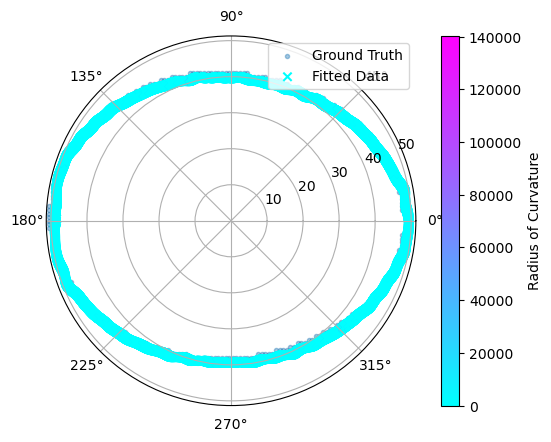

In [39]:
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=min(radii_curvature), vmax=max(radii_curvature))

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.scatter(radiances, radius, marker='.', label='Ground Truth', alpha=0.4) 
ax.scatter(phi_domain, r_data, c=radii_curvature, cmap=cmap, marker='x', label='Fitted Data') 
ax.legend(loc="upper right")
fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
    ax=ax, orientation='vertical', label='Radius of Curvature'
)

In [ ]:
# V = V.subs(sub_values)
# S = S.subs(sub_values)
# print("Volume = ", sympy.N(V))
# print("Surface Area = ", sympy.N(S))